In [29]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

In [30]:
train_img_dir = "Dataset/data_for_keras_aug/train_images/train"
train_mask_dir = "Dataset/data_for_keras_aug/train_masks/train"

img_list = os.listdir(train_img_dir)
mask_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


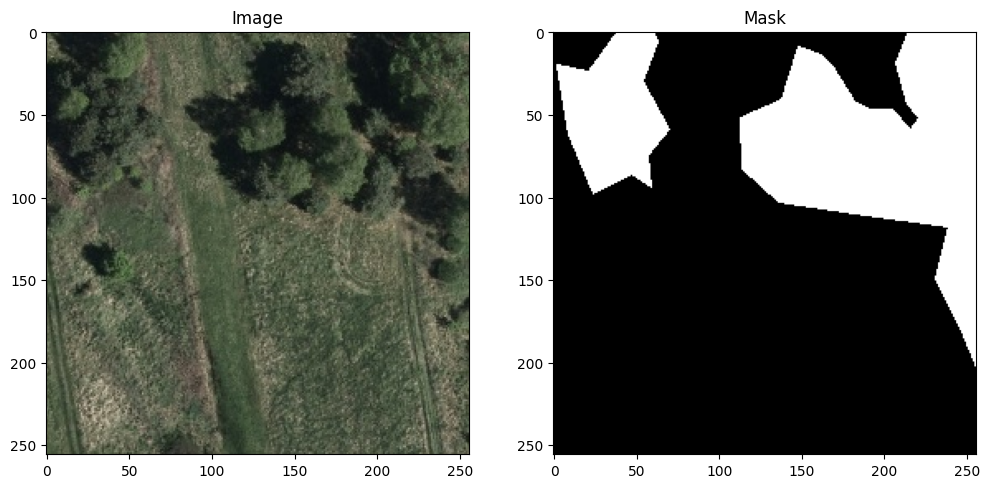

In [31]:
img_num = random.randint(0,num_images-1)

img_for_plot = cv2.imread(train_img_dir+"//"+img_list[img_num],1)
img_for_plot = cv2.cvtColor(img_for_plot,cv2.COLOR_BGR2RGB)

mask_for_plot = cv2.imread(train_mask_dir+"//"+mask_list[img_num],0)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot,cmap="gray")
plt.title('Mask')
plt.show()

In [32]:
seed = 42
batch_size = 4
n_classes = 4

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from keras.utils import to_categorical

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [33]:
def preprocess_data(img,mask,num_class):
    img = scaler.fit_transform(img.reshape(-1,img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)

    mask = to_categorical(mask,num_class)

    return (img,mask)

In [34]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path,train_mask_path,num_class):

    img_data_gen_args = dict(horizontal_flip=True,vertical_flip=True,fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    
    image_generator =image_datagen.flow_from_directory(train_img_path,class_mode=None,batch_size=batch_size,seed=seed)
    mask_generator =mask_datagen.flow_from_directory(train_mask_path,class_mode=None,color_mode ='grayscale',batch_size=batch_size,seed=seed)

    train_generator= zip(image_generator,mask_generator)

    for (img,mask) in train_generator:
        img,mask = preprocess_data(img, mask,num_class)
        yield (img,mask)
 

In [35]:
train_img_path = "Dataset/data_for_keras_aug/train_images/"
train_mask_path = "Dataset/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path,train_mask_path,num_class=4)

val_img_path = "Dataset/data_for_keras_aug/val_images/"
val_mask_path = "Dataset/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path,val_mask_path,num_class=4)

x,y=train_img_gen.__next__()


Found 15056 images belonging to 1 classes.
Found 15056 images belonging to 1 classes.


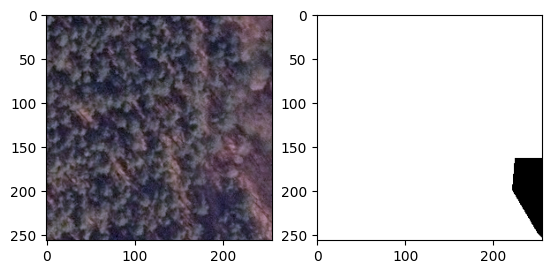

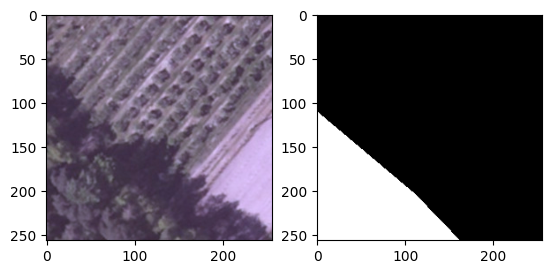

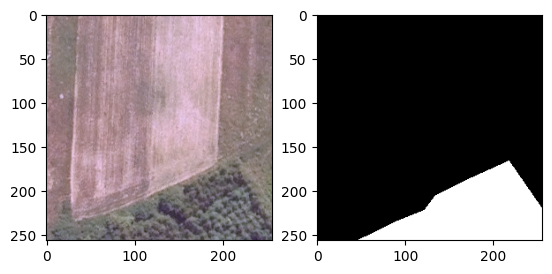

Found 5019 images belonging to 1 classes.
Found 5019 images belonging to 1 classes.


In [36]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i],axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.show()

x_val, y_val = val_img_gen.__next__()

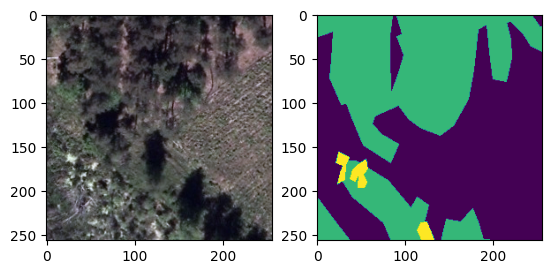

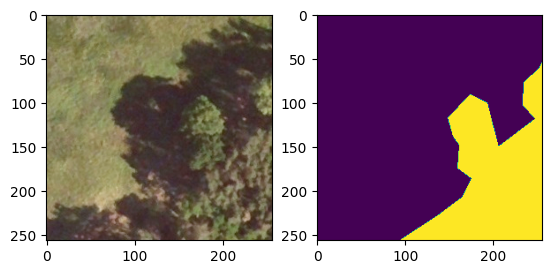

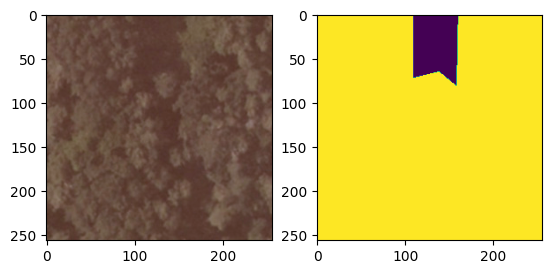

In [37]:
for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i],axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()


In [38]:
num_train_imgs = len(os.listdir(train_img_dir))
num_val_images = len(os.listdir('Dataset/data_for_keras_aug/val_images/val'))
steps_per_epochs = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes = 4

In [39]:
model = sm.Unet(BACKBONE,encoder_weights='imagenet',input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),classes=n_classes,activation='softmax')
model.compile('Adam', loss= sm.losses.categorical_focal_jaccard_loss,metrics=[sm.metrics.iou_score])

In [41]:
history = model.fit(train_img_gen,steps_per_epoch=steps_per_epochs,epochs=25,verbose=1,validation_data=val_img_gen,validation_steps=val_steps_per_epoch)
model.save('landcover_model.h5')

Epoch 1/25
3764/3764 [==============================] - 1326s 349ms/step - loss: 0.6449 - iou_score: 0.4018 - val_loss: 0.6544 - val_iou_score: 0.4071
Epoch 2/25
3764/3764 [==============================] - 819s 218ms/step - loss: 0.5633 - iou_score: 0.4758 - val_loss: 0.5715 - val_iou_score: 0.4583
Epoch 3/25
3764/3764 [==============================] - 777s 206ms/step - loss: 0.5386 - iou_score: 0.4973 - val_loss: 0.5410 - val_iou_score: 0.4832
Epoch 4/25
3764/3764 [==============================] - 770s 205ms/step - loss: 0.5216 - iou_score: 0.5124 - val_loss: 0.5346 - val_iou_score: 0.4924
Epoch 5/25
3764/3764 [==============================] - 770s 205ms/step - loss: 0.5091 - iou_score: 0.5229 - val_loss: 0.5150 - val_iou_score: 0.5083
Epoch 6/25
3764/3764 [==============================] - 771s 205ms/step - loss: 0.5039 - iou_score: 0.5273 - val_loss: 0.5178 - val_iou_score: 0.5066
Epoch 7/25
3764/3764 [==============================] - 772s 205ms/step - loss: 0.4921 - iou_score:

In [42]:
from keras.models import load_model
model = load_model("landcover_model.h5",compile=False)

In [43]:
test_image_batch,test_mask_batch = val_img_gen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch,axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch,axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax,test_mask_batch_argmax)
print("Mean IoU =",IOU_keras.result().numpy())

1/1 [==============================] - 1s 1s/step
Mean IoU = 0.82563263


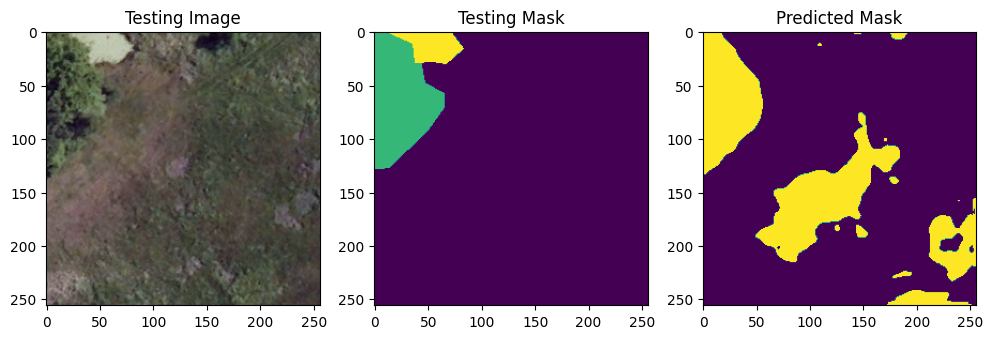

In [46]:
img_num = random.randint(0,test_image_batch.shape[0]-1)

plt.figure(figsize=(12,8))

plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_image_batch[img_num])

plt.subplot(232)
plt.title("Testing Mask")
plt.imshow(test_mask_batch_argmax[img_num])

plt.subplot(233)
plt.title("Predicted Mask")
plt.imshow(test_pred_batch_argmax[img_num])

plt.show()
